# Doc 9 - Densenet com dataset completo e input padrão

Agora que temos o dataset completo em formato .png, vamos experimentar utilizá-lo para o treinamento em diferentes modelos de CNNs. Vamos começar usando a DenseNet com as especificações do paper.

Inicialmente tentei realizar o transfer learning com todos os layers da rede DenseNet congelados, o que gerou resultados ruins com overfitting, assim como já havia acontecido.

Depois rodei o código novamente, mas agora com todos os layers descongelados.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
import pandas as pd
import os
import shutil
import numpy as np
import seaborn as sns

C:\Users\breno\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1 - Visualização da base de dados

In [2]:
#Função para visualização
def plot_image_counts(folder_path):
    #Contadores pra plotar
    counts = {'actionable': 0, 'benign': 0, 'cancer': 0, 'normal': 0}

    #Vai olhar os folders
    total_images = 0
    for class_name in counts.keys():
        class_path = os.path.join(folder_path, class_name)
        if os.path.exists(class_path):
            class_count = len(os.listdir(class_path))
            counts[class_name] = class_count
            total_images += class_count

    #Cálculo da porcentagem
    percentages = {class_name: count / total_images * 100 for class_name, count in counts.items()}

    #Plot dos gráficos
    plt.figure(figsize=(10, 6))
    plt.bar(percentages.keys(), percentages.values(), color=['blue', 'green', 'red', 'purple'])
    plt.xlabel('Classe')
    plt.ylabel('Porcentagem')
    plt.title('Porcentagem de imagens em cada classe')
    plt.show()

    #Tabelinha
    df = pd.DataFrame({'Quantidade': counts.values(), 'Porcentagem': percentages.values()}, index=counts.keys())
    print("Tabela quantidade-porcentagem:")
    print(df)

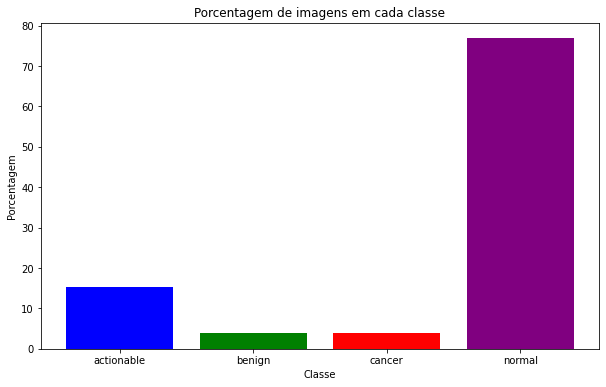

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         240    15.374760
benign              61     3.907751
cancer              60     3.843690
normal            1200    76.873799


In [3]:
#Test set
folder_path = r'D:/Coisinhas/Coisas_UNB/TCC/dataset_png/test'
plot_image_counts(folder_path)

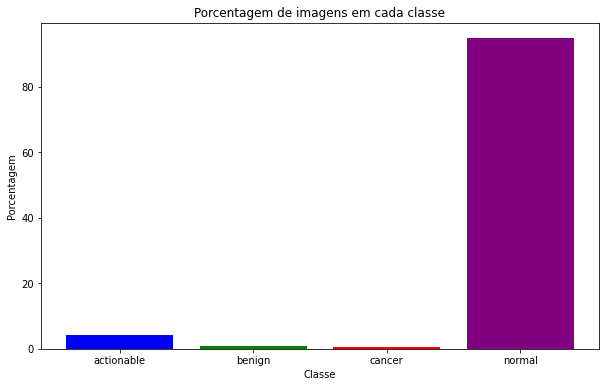

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         712     4.104220
benign             124     0.714780
cancer              76     0.438091
normal           16436    94.742910


In [4]:
#Training set
folder_path = r'D:/Coisinhas/Coisas_UNB/TCC/dataset_png/train'
plot_image_counts(folder_path)

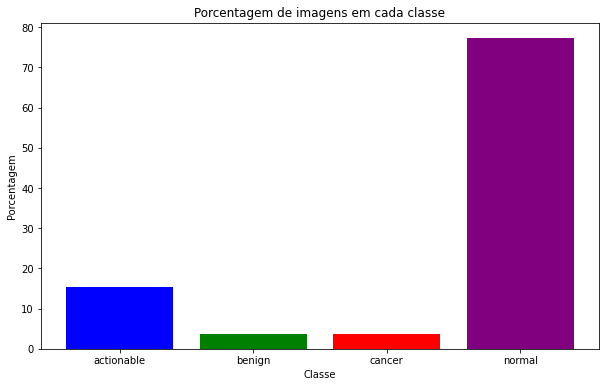

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         160    15.458937
benign              38     3.671498
cancer              37     3.574879
normal             800    77.294686


In [5]:
#Validation set
folder_path = r'D:/Coisinhas/Coisas_UNB/TCC/dataset_png/val'
plot_image_counts(folder_path)

# 2 - Modelo baseado no paper

O modelo do paper possui as seguintes especificações:

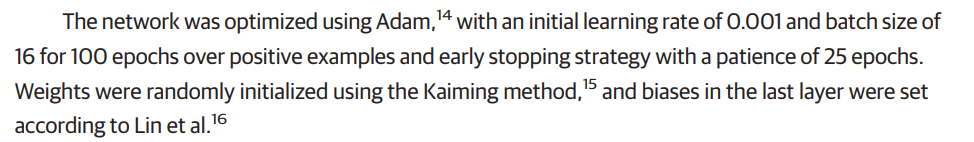
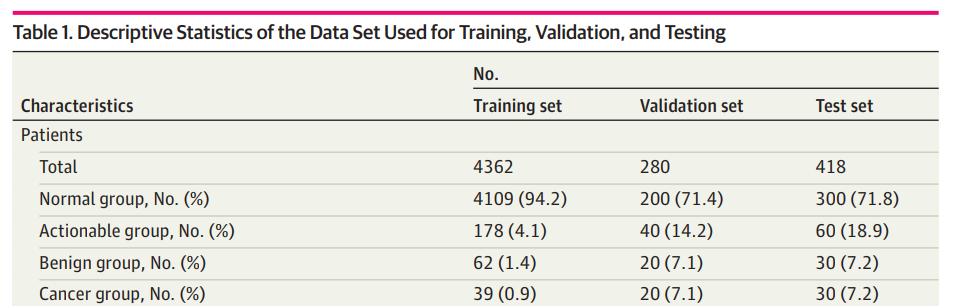

Com isso, vamos criar uma nova pasta com essas quantidades. Preferi utilizar a quantidade total de imagens das classes que não são classificadas como "normal", fez mais sentido para mim do que reduzí-las.

In [18]:
#Paths para as pastas
source_dir = r"D:\Coisinhas\Coisas_UNB\TCC\dataset_png"
dest_dir = "paper_dataset"

#Cria o diretorio
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

#Funcao para transferir as imagens
def copy_images(source_path, dest_path, num_images_normal):
    classes = os.listdir(source_path)
    for class_name in classes:
        class_path = os.path.join(source_path, class_name)
        dest_class_path = os.path.join(dest_path, class_name)
        if not os.path.exists(dest_class_path):
            os.makedirs(dest_class_path)
        images = os.listdir(class_path)
        
        #Vai pegar apenas o numero de imagens normal que queremos
        if class_name == "normal":
            images_to_copy = images[:num_images_normal]
        
        #O resto vai pegar tudo
        else:
            images_to_copy = images
        for image in images_to_copy:
            shutil.copy(os.path.join(class_path, image), dest_class_path)

#Train
train_source_path = os.path.join(source_dir, "train")
train_dest_path = os.path.join(dest_dir, "train")
copy_images(train_source_path, train_dest_path, 4109)

#Test
test_source_path = os.path.join(source_dir, "test")
test_dest_path = os.path.join(dest_dir, "test")
copy_images(test_source_path, test_dest_path, 300)

#Val
val_source_path = os.path.join(source_dir, "val")
val_dest_path = os.path.join(dest_dir, "val")
copy_images(val_source_path, val_dest_path, 200)

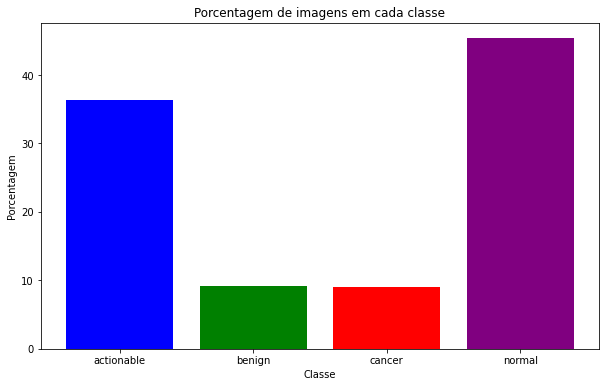

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         240    36.308623
benign              61     9.228442
cancer              60     9.077156
normal             300    45.385779


In [6]:
#Test set novo
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 9 - Densenet com dataset completo\paper_dataset\test'
plot_image_counts(folder_path)

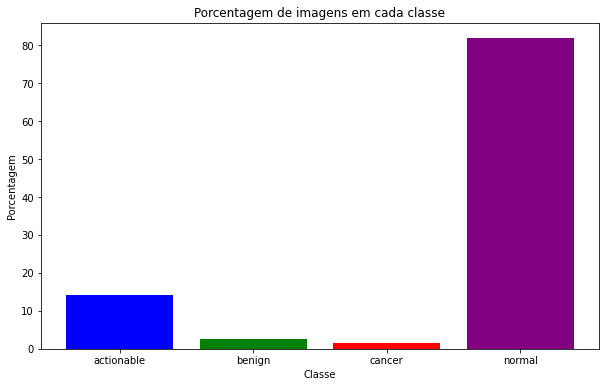

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         712    14.180442
benign             124     2.469628
cancer              76     1.513643
normal            4109    81.836288


In [7]:
#Train set novo
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 9 - Densenet com dataset completo\paper_dataset\train'
plot_image_counts(folder_path)

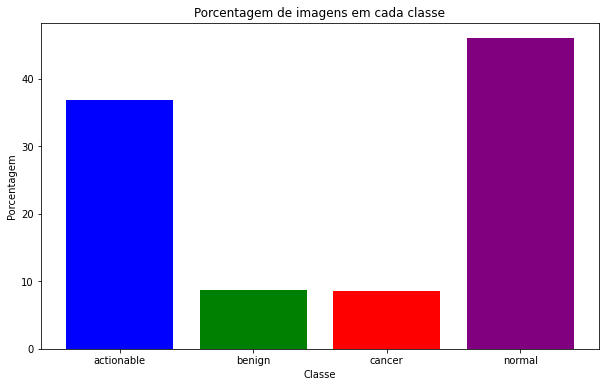

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         160    36.781609
benign              38     8.735632
cancer              37     8.505747
normal             200    45.977011


In [8]:
#Validation set novo
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 9 - Densenet com dataset completo\paper_dataset\val'
plot_image_counts(folder_path)

In [9]:
#Diretórios
train_dir = r'D:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 9 - Densenet com dataset completo\paper_dataset\train'
val_dir = r'D:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 9 - Densenet com dataset completo\paper_dataset\val'
test_dir = r'D:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 9 - Densenet com dataset completo\paper_dataset\test'

#Set das dimensões
img_width, img_height = 224, 224 #Shape padrão da densenet
input_shape = (img_width, img_height, 3)

#Batch size
batch_size = 16

#CLasses
num_classes = 4

In [10]:
#Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height), #Descobri que o resize é feito automaticamente pelos generators.
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 5021 images belonging to 4 classes.
Found 435 images belonging to 4 classes.
Found 661 images belonging to 4 classes.


In [11]:
#Transfer learning com a densenet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

#Congelando os pesos e trocando o último layer para nossas 4 classes
#for layer in base_model.layers:
#    layer.trainable = False
    
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
#Compilar o modelo
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

In [14]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping])

Epoch 1/100


C:\Users\breno\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


314/314 ━━━━━━━━━━━━━━━━━━━━ 2341s 7s/step - accuracy: 0.7035 - loss: 6.4047 - val_accuracy: 0.4598 - val_loss: 112879.9609
Epoch 2/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 2081s 7s/step - accuracy: 0.7891 - loss: 0.8624 - val_accuracy: 0.4598 - val_loss: 2.1611
Epoch 3/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 2220s 7s/step - accuracy: 0.8228 - loss: 0.6033 - val_accuracy: 0.4598 - val_loss: 1.3896
Epoch 4/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1945s 6s/step - accuracy: 0.8083 - loss: 0.6423 - val_accuracy: 0.4598 - val_loss: 1.6229
Epoch 5/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 2029s 6s/step - accuracy: 0.8206 - loss: 0.5949 - val_accuracy: 0.4598 - val_loss: 1.3246
Epoch 6/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 2129s 7s/step - accuracy: 0.8223 - loss: 0.5990 - val_accuracy: 0.4598 - val_loss: 1.4678
Epoch 7/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1961s 6s/step - accuracy: 0.8212 - loss: 0.5995 - val_accuracy: 0.4598 - val_loss: 1.4330
Epoch 8/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 2025s 6s/step - accuracy: 0.8125 - loss: 0.6149 -

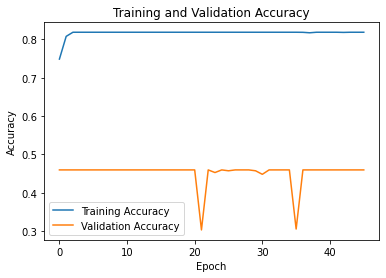

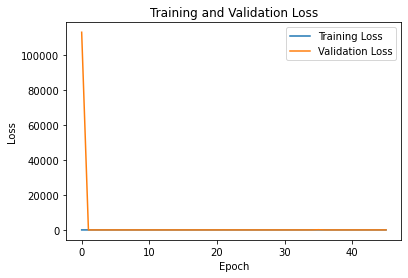

In [15]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

42/42 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.4653 - loss: 1.2844
Test Accuracy: 45.39%
Test Loss: 1.3578


In [17]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

42/42 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [18]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

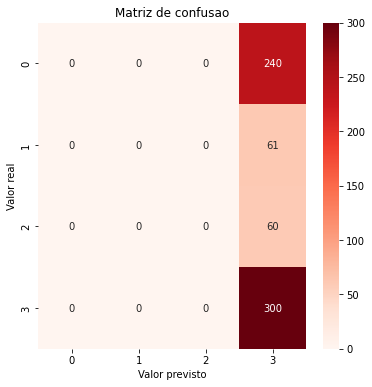

In [19]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

# 3 - Conclusões

Usar tanto todos os layers congelados como também descongelados gerou resultados ruins.

Congelar todos os layers, no caso dessa rede, pode não ser uma boa ideia por conta da "falta de conexão" entre o nosso dataset e com o que a rede foi treinada. Como a os pesos da rede não foram gerados originalmente com deteccção de cancer em mente, a rede pode não ser boa nessa tarefa.

Descongelar todos os layers também não trouxe resultados bons, muito provavelmente por conta da enorme complexidade da rede e o tamanho "pequeno" do dataset em si. 

Com isso, uma possibilidade do que fazer usando a DenseNet seria realizar um fine-tuning e ir descongelando seus layers aos poucos. 

O sentido por trás disso vem do fato de que, à medida que vamos criando mais layers em uma CNN, a complexidade daquilo que os layers estão detectando também vai aumentando. Em outras palavras, os layers iniciais buscam detectar coisas como bordas e padrões simples, enquanto que os layers mais no fim da rede vão detectar coisas mais complexas, como por exemplo um cachorro como um todo.

Deixar registrado então a necessidade de um fine-tuning, descongelando os layers finais aos poucos para ver o resultado.

Outra coisa - Para esse teste eu tentei utilziar na entrada as dimensões de input da propria densenet (224x224), o que provavelmente também resultou na rede não aprender. Voltar a usar dimensões maiores e fazer o resize das documentações passadas.

Outro ponto importante é que não é nem um overfitting, porque a rede não está aprendendo, só jogou tudo para o com mais imagens.